# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
1. /datasets/geo_data_0.csv
2. /datasets/geo_data_1.csv
3. /datasets/geo_data_2.csv

<br> `id` — уникальный идентификатор скважины;
<br> `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
<br> `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
<br> Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
<br> При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
<br> Бюджет на разработку скважин в регионе — 10 млрд. рублей.
<br> При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
<br> После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
<br> Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
# загрузим библиотеки, которые пригодятся при анализе и построинии модели

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

Загрузим данные по регионам

In [2]:
data_1 = pd.read_csv('/datasets/geo_data_0.csv')
data_1.info()
data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
data_2 = pd.read_csv('/datasets/geo_data_1.csv')
data_2.info()
data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
data_3 = pd.read_csv('/datasets/geo_data_2.csv')
data_3.info()
data_3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [5]:
# проверим пропуски и дубликаты в данных
def research(data):
    print("Пропущенные данные:", data.isna().sum().sum())
    print("Наличие дубликатов:", data.duplicated().sum())
    data[['f0', 'f1', 'f2', 'product']].hist(bins=25, figsize=(10,8))
    plt.show()

Пропущенные данные: 0
Наличие дубликатов: 0


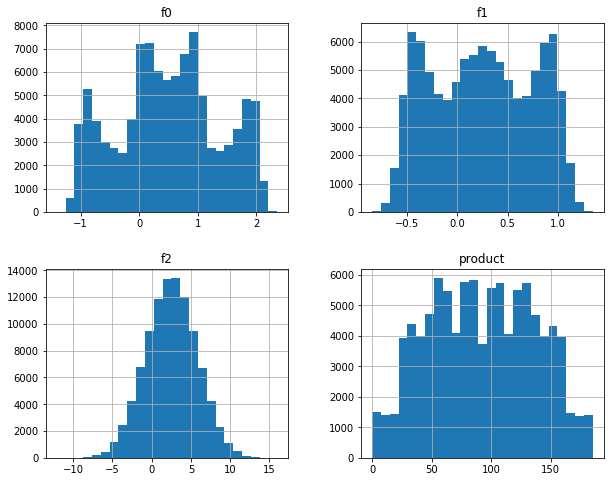

In [6]:
research(data_1)

Пропущенные данные: 0
Наличие дубликатов: 0


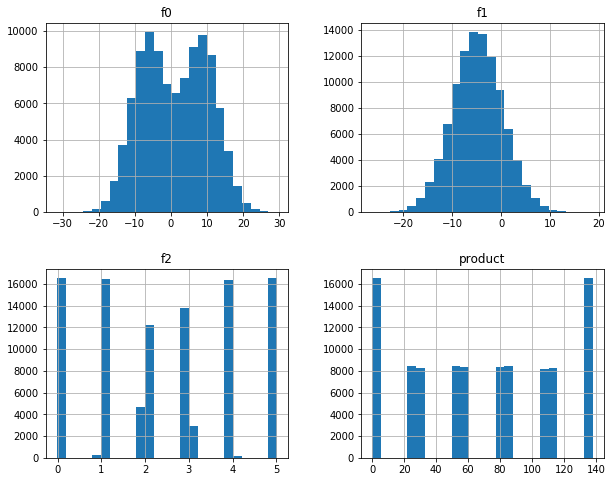

In [7]:
research(data_2)

Пропущенные данные: 0
Наличие дубликатов: 0


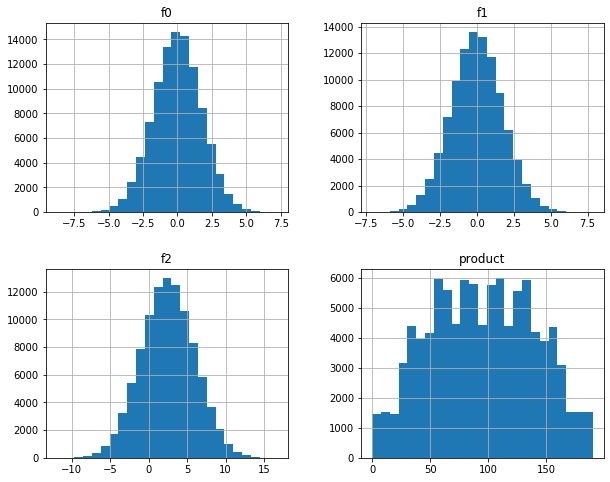

In [8]:
research(data_3)

**Вывод:**

<br> Данные по трем регионам состоят из 100000 записей, пропусков и дубликатов в данных нет.
<br> По представленным гистограммам видно, что распределения по первому и третьиму регионы похожи на нормальные, но распределение второго региона отличаются по признаку f2 и объему запасов нефти.

Проверим кол-во нулевых запасов нефти по каждому региону

In [9]:
data_1[data_1['product'] == 0].count()

id         1
f0         1
f1         1
f2         1
product    1
dtype: int64

In [10]:
data_2[data_2['product'] == 0].count()

id         8235
f0         8235
f1         8235
f2         8235
product    8235
dtype: int64

In [11]:
data_3[data_3['product'] == 0].count()

id         1
f0         1
f1         1
f2         1
product    1
dtype: int64

удалим столбцы `id` в виду бесполезности для проекта

In [12]:
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)
data_3 = data_3.drop(['id'], axis=1)

**Вывод:**

<br> Предыдущие выводы подтвердились, ненормальное распределение по второму региону связано скорее всего с нулевыми значениями по объему запасов скважин - 8235 записей.
<br> Данные готовы для работы.

## Обучение и проверка модели

В ходе этапа обучим и проверим модель для каждого региона:
- разобъем данные на обучающую и валидационную выборки в соотношении 75:25
- обучим модель и сделаем предсказания на валидационной выборке
- сохраним предсказания и правильные ответы на валидационной выборке
- напечатаем на экране средний запас предсказанного сырья и RMSE модели
- сделаем выводы

In [13]:
# запишем функцию для расчетов:
def my_train_test_split(data):
    
    features = data.drop(["product"], axis=1) # выделим в данных признаки
    target = data["product"] # выделим из данных целевой признак
    
    # разобъем данные на выборки
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=1)
    
    # масштабируем данные
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train) # масштабируем численные признаки обучающей выборки
    features_valid = scaler.transform(features_valid) # масштабируем численные признаки валидационной выборки
    
    # обучим модель на линейной регрессии, сделаем предсказания, рассчитаем RMSE и средний объем запаса сырья
    model = LinearRegression(normalize=False)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions)
    RMSE = (mean_squared_error(predictions, target_valid))**0.5
    average_product = sum(predictions) / len(predictions)
    
    print('RMSE модели: {0:.2f}'.format(RMSE))
    print('Средний объем запаса сырья: {0:.2f}'.format(average_product))
    
    return (predictions, target_valid.reset_index(drop=True), RMSE)



Выведем значения функции с RMSE моделью и средним запасом предсказанного сырья

In [14]:
predictions_1, validation_1, RMSE_1 = my_train_test_split(data_1)

RMSE модели: 37.74
Средний объем запаса сырья: 92.49


In [15]:
predictions_2, validation_2, RMSE_2 = my_train_test_split(data_2)

RMSE модели: 0.89
Средний объем запаса сырья: 69.12


In [16]:
predictions_3, validation_3, RMSE_3 = my_train_test_split(data_3)

RMSE модели: 39.87
Средний объем запаса сырья: 94.96


**Вывод:**

<br> С наибольшим значением RMSE = 0,89 модель предсказала средние объемы запасов сырья **во втором** регионе, но само значение среднего запаса сырья минемальное из всех регионов = 69,12. Это может быть отсылкой к предыдущим выводам о наличии во втором регионе нулевых значений по запасам.
Следующий шаг покажет есть ли прибыльность в регионах.
<br> Значения по 1му и 2му регионам примерно одинаковые и по RMSE и по средним объемам запасов сырья.

## Подготовка к расчёту прибыли

Подготовка к расчёту прибыли:
- все ключевые значения для расчётов сохраним в отдельных переменных
- рассчитаем достаточный объём сырья для безубыточной разработки новой скважины
- сравним полученный объём сырья со средним запасом в каждом регионе
- напишем выводы

In [17]:
Total_points = 500
Best_points = 200
Income_per_K_barrel = 450 # тыс руб за 1 тыс.бар
Budget = 10000000 # тыс руб за 1 тыс.бар

In [18]:
# рассчитаем точку безубыточности
X = Budget / Income_per_K_barrel
print('Точка безубыточности: {0:.0f} тыс. баррелей'.format(X))

Точка безубыточности: 22222 тыс. баррелей


In [19]:
average_barrels_per_point = X / Best_points
print('Средний объем нефти на скважину: {0:.0f} тыс. баррелей'.format(average_barrels_per_point))

Средний объем нефти на скважину: 111 тыс. баррелей


In [20]:
# рассчитаем средний объем запаса сырья на скважину в каждом регионе
print('Средний объем запаса сырья на скважину в регионе 1 {0:.0f} тыс.баррелей'.format(data_1['product'].mean()))
print('Средний объем запаса сырья на скважину в регионе 2 {0:.0f} тыс.баррелей'.format(data_2['product'].mean()))
print('Средний объем запаса сырья на скважину в регионе 3 {0:.0f} тыс.баррелей'.format(data_3['product'].mean()))

Средний объем запаса сырья на скважину в регионе 1 93 тыс.баррелей
Средний объем запаса сырья на скважину в регионе 2 69 тыс.баррелей
Средний объем запаса сырья на скважину в регионе 3 95 тыс.баррелей


In [21]:
# рассчитаем объем запаса сырья в каждом регионе
print('Объем запаса сырья в регионе 1 {0:.0f} тыс.баррелей'.format(data_1['product'].sum()))
print('Объем запаса сырья в регионе 2 {0:.0f} тыс.баррелей'.format(data_2['product'].sum()))
print('Объем запаса сырья в регионе 3 {0:.0f} тыс.баррелей'.format(data_3['product'].sum()))

Объем запаса сырья в регионе 1 9250000 тыс.баррелей
Объем запаса сырья в регионе 2 6882500 тыс.баррелей
Объем запаса сырья в регионе 3 9500000 тыс.баррелей


**Вывод:** из полученных расчетов видно, что не по одному региону не хватает средних запасов на скважину (если рассматривать 200 точек), но общего объема баррелей по региону достаточно. Это говорит о том, что скважин должно быть больше 200 для достижения безубыточности (диапазон от 234 до 323 для разных регионов)

## Расчёт прибыли и рисков 

Напишим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- выбирем скважины с максимальными значениями предсказаний
- просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям
- рассчитаем прибыль для полученного объёма сырья

Далее посчитаем риски и прибыль для каждого региона:
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
- найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков
- сделаем выводы: предложим регион для разработки скважин и обоснуем выбор


In [22]:
# напишем функцию для расчета прибыли на 200 разведанных точек
def profit(predictions, target):
    top_predictions = predictions.sort_values(ascending=False)
    top_target = target[top_predictions.index][:200]
    return top_target.sum() * Income_per_K_barrel - Budget

In [23]:
state = np.random.RandomState(12345)

In [24]:
# напишем функцию для применения техники Bootstrap с 1000 выборок для определения средней прибыли и рисков убытков
def bootstrap_1000(target, predictions):
    values = []
    loss_risk = 0
    for i in range(1000):
        target_sample = target.sample(500, replace=True, random_state=state)
        predictions_sample = predictions[target_sample.index]
        profit_1 = profit(target_sample, predictions_sample)
        #if profit_1 < 0:
        #    loss_risk += 1
        values.append(profit_1)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = sum(values) / len(values)
    #risk = loss_risk / 1000
    risk = (values < 0).mean()
    return average, lower, upper, risk

In [25]:
average_1, lower_1, upper_1, risk_1 = bootstrap_1000(predictions_1, validation_1)
print('1й регион:')
print('Средняя прибыль по региону = {:.2f} млн.руб.'.format(average_1/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} млн.руб.'.format(lower_1/1000, upper_1/1000))
print('Риск потерь {:.2%}'.format(risk_1))

1й регион:
Средняя прибыль по региону = 458.10 млн.руб.
95% доверительный интервал от -91.94 до 1015.82 млн.руб.
Риск потерь 4.60%


In [26]:
average_2, lower_2, upper_2, risk_2 = bootstrap_1000(predictions_2, validation_2)
print('2й регион:')
print('Средняя прибыль по региону = {:.2f} млн.руб.'.format(average_2/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} млн.руб.'.format(lower_2/1000, upper_2/1000))
print('Риск потерь {:.2%}'.format(risk_2))

2й регион:
Средняя прибыль по региону = 533.06 млн.руб.
95% доверительный интервал от 99.43 до 973.06 млн.руб.
Риск потерь 0.60%


In [27]:
average_3, lower_3, upper_3, risk_3 = bootstrap_1000(predictions_3, 
                                                     validation_3)
print('3й регион:')
print('Средняя прибыль по региону = {:.2f} млн.руб.'.format(average_3/1000))
print('95% доверительный интервал от {:.2f} до {:.2f} млн.руб.'.format(lower_3/1000, upper_3/1000))
print('Риск потерь {:.2%}'.format(risk_3))

3й регион:
Средняя прибыль по региону = 411.08 млн.руб.
95% доверительный интервал от -138.94 до 959.38 млн.руб.
Риск потерь 7.20%


**Вывод:**

Второй регион для реализации проекта является наиболее привлекательным в виду наибольшей средней прибыли = 528 млн. руб. и наименьшего процента риска = менее 1% (требование задачи - менее 2,5%)

**Вывод по проекту:**

1. Данные были загружены, проверены и приняты в работу.
2. Была обучена модель Линейной регрессии с расчетом RSME и средним запасом сырья по скважинам по каждому региону.
3. Была расчитана точка безубыточности по проекту - 22 млн.баррелей при инвестициях в 10 млрд.руб.
4. Была расчитана средняя прибыль по каждому региону и определен риск возможных потерь.
5. Для реализации проекта предлагается второй регион как наиболее прибыльный (527,8 млн.руб - средняя прибыль) с минимальным уровнем риска (менее 1 %).